#1. Influencer Activation Data against User Actions

A very simple test model for the effect of influencer events on user actions is built as follows:

Normalized user action on day (s+t) = $\alpha$ +  $\gamma(s)$ \* Normalized User action on day (s+t-1) + $\beta(s)$ \* Indicator(Influencer Event on day s) * (Number of Followers of the Influencer on day t) 

where: 
* Indicator(Influencer Event) = 1 if there's an influencer event and 0 otherwise
* User Action includes counts of ITunes Installs, Active Users, New Users, Sessions, Registrations, Purchases and Hooks Dropped. 
* Normalized User Action refers to user actions normalized by the day-ofweek periodicity, as well as by the average user action level of the past week

We then plot $\beta(s)$,$\gamma(s)$, with $s$ going from zero to one month, to get a sense of how the effect of influencers decay over time. For simplicity we ignore the fact that there can be multiple influencer events in close proximity to each other, which we expect to show up as bumps in the decay function. 


In [1]:
import pandas
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.special
from matplotlib import pyplot as plt
%matplotlib inline


In [105]:
myfile = pandas.ExcelFile('/home/ms142/museami/Hook\'d Track Engagement Performance.xlsx')
df = pandas.ExcelFile.parse(myfile,sheetname='Daily Filtered',index_col=2).transpose()

In [3]:
myfile = pandas.ExcelFile('/home/ms142/museami/Copy of Niche Influencer Activation Data.xlsx')
niche = pandas.ExcelFile.parse(myfile,index_col=0).dropna()
niche.rename(columns=lambda x : x.replace(' ','_'),inplace=True)

In [4]:
myfile = pandas.ExcelFile('/home/ms142/museami/Google Analytics Data Extraction Mk II.xlsx')
engagement = pandas.ExcelFile.parse(myfile,sheetname='Engagement Daily',header=1,index_col=0).dropna()
engagement.index = pandas.DatetimeIndex(engagement.index)
engagement.rename(columns={'1 day':'Regs','1 day.1':'Sales_Count','1 day.2':'Hooks_Dropped'},inplace=True)
engagement = engagement[['Regs','Sales_Count','Hooks_Dropped']]
alldaily = pandas.ExcelFile.parse(myfile,sheetname='All Daily',header=1,index_col=0).dropna()
alldaily.index = pandas.DatetimeIndex(alldaily.index)
alldaily.rename(columns={'1 day':'Install','1 day.1':'Active','1 day.2':'New','1 day.3':'Session'},inplace=True)
alldaily = alldaily[['Install','Active','New','Session']]

The seven user actions ('Regs, 'Sales Count','Hooks Dropped','Install','Active','New User','Session') are collected above. 

In [5]:
engagement=engagement.join(alldaily)

In [7]:
niche['Number_of_Followers']=niche['Number_of_Followers'].str.replace('M','').astype(float)

Correct for day of week periodicity:

In [8]:
engagement['weekday']=engagement.index.weekday.astype(int)
weekdayAvg = engagement.groupby('weekday').median()
weekdayAvg = weekdayAvg.divide(weekdayAvg.mean(axis=0))

In [9]:
def normalize(row):
    wd = int(row['weekday'])
    row[weekdayAvg.columns] = row[weekdayAvg.columns]/weekdayAvg.loc[wd]
    return row

In [10]:
engagement=engagement.apply(normalize,axis=1) #remember not to apply more than once

In [11]:
rollingRegs = pandas.rolling_mean(engagement['Regs'],7)
rollingSales = pandas.rolling_mean(engagement['Sales_Count'],7)
rollingHooks = pandas.rolling_mean(engagement['Hooks_Dropped'],7)
rollingInstalls = pandas.rolling_mean(engagement['Install'],7)
rollingActives = pandas.rolling_mean(engagement['Active'],7)
rollingNews = pandas.rolling_mean(engagement['New'],7)
rollingSessions = pandas.rolling_mean(engagement['Session'],7)

avgRegs = engagement['Regs'].loc[niche.index[0]:].mean()
avgSales = engagement['Sales_Count'].loc[niche.index[0]:].mean()
avgHooks = engagement['Hooks_Dropped'].loc[niche.index[0]:].mean()

A quick sanity check verifies that the influencer variable has a high t-statistic on user actions of the same day:

In [12]:
engagement['rollingInstalls'] = rollingInstalls.shift(1)
engagement['normInstalls'] = (engagement['Install'].shift(0))/engagement['rollingInstalls']
engagement['normInstalls_lag1'] = engagement['normInstalls'].shift(1)
infeffect = niche.join(engagement,how='right')
infeffect['Number_of_Followers'].fillna(0,inplace=True)
res = smf.ols(data=infeffect,formula='normInstalls ~ Number_of_Followers + normInstalls_lag1').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           normInstalls   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     56.42
Date:                Sun, 15 Mar 2015   Prob (F-statistic):           1.12e-20
Time:                        13:14:36   Log-Likelihood:                -42.260
No. Observations:                 234   AIC:                             90.52
Df Residuals:                     231   BIC:                             100.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               0.4664      0.057      8.221      0.000         0.355     0.578
Number_of_Followers     0.0802      0.015      5.196      0.000         0.050     0.111
normInstalls_lag1       0.5092      0.054      9.482      0.000         0.403     0.615
==============================================================================
Omnibus:                      148.512   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2022.685
Skew:                           2.215   Prob(JB):                         0.00
Kurtosis:                      16.705   Cond. No.                         6.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
onRegs=[]
onSales=[]
onHooks=[]
onInstalls=[]
onActives=[]
onNews=[]
onSessions=[]
autoRegs=[]
autoSales=[]
autoHooks=[]
autoInstalls=[]
autoActives=[]
autoNews=[]
autoSessions=[]

dayLag = range(0,31)
infcolumn = 'Number_of_Followers'
for i in dayLag:
    engagement['rollingInstalls'] = rollingInstalls.shift(-i+1)
    engagement['rollingActives'] = rollingActives.shift(-i+1)
    engagement['rollingNews'] = rollingNews.shift(-i+1)
    engagement['rollingSessions'] = rollingSessions.shift(-i+1)    
    engagement['rollingRegs'] = rollingRegs.shift(-i+1)
    engagement['rollingSales'] = rollingSales.shift(-i+1)
    engagement['rollingHooks'] = rollingHooks.shift(-i+1)
    engagement['normInstalls'] = (engagement['Install'].shift(-i))/engagement['rollingInstalls']
    engagement['normActives'] = (engagement['Active'].shift(-i))/engagement['rollingActives']
    engagement['normNews'] = (engagement['New'].shift(-i))/engagement['rollingNews']
    engagement['normSessions'] = (engagement['Session'].shift(-i))/engagement['rollingSessions']
    engagement['normRegs'] = (engagement['Regs'].shift(-i))/engagement['rollingRegs']
    engagement['normSales'] = (engagement['Sales_Count'].shift(-i))/engagement['rollingSales']
    engagement['normHooks'] = (engagement['Hooks_Dropped'].shift(-i))/engagement['rollingHooks']
    engagement['normInstalls_lag1'] = engagement['normInstalls'].shift(1)
    engagement['normActives_lag1'] = engagement['normActives'].shift(1)
    engagement['normNews_lag1'] = engagement['normNews'].shift(1)
    engagement['normSessions_lag1'] = engagement['normSessions'].shift(1)
    engagement['normRegs_lag1'] = engagement['normRegs'].shift(1)
    engagement['normSales_lag1'] = engagement['normSales'].shift(1)
    engagement['normHooks_lag1'] = engagement['normHooks'].shift(1)
    infeffect = niche.join(engagement,how='right')
    infeffect[infcolumn].fillna(0,inplace=True)
    res = smf.ols(data=infeffect,formula='normInstalls ~ '+infcolumn+' + normInstalls_lag1').fit()
    onInstalls.append(getattr(res.params,infcolumn))
    autoInstalls.append(getattr(res.params,'normInstalls_lag1'))
    res = smf.ols(data=infeffect,formula='normActives ~ '+infcolumn+' + normActives_lag1').fit()
    onActives.append(getattr(res.params,infcolumn))
    autoActives.append(getattr(res.params,'normActives_lag1'))
    res = smf.ols(data=infeffect,formula='normNews ~ '+infcolumn+' + normNews_lag1').fit()
    onNews.append(getattr(res.params,infcolumn))
    autoNews.append(getattr(res.params,'normNews_lag1'))
    res = smf.ols(data=infeffect,formula='normSessions ~ '+infcolumn+' + normSessions_lag1').fit()
    onSessions.append(getattr(res.params,infcolumn))
    autoSessions.append(getattr(res.params,'normSessions_lag1'))
    res = smf.ols(data=infeffect,formula='normRegs ~ '+infcolumn+' + normRegs_lag1').fit()
    onRegs.append(getattr(res.params,infcolumn))
    autoRegs.append(getattr(res.params,'normRegs_lag1'))
    res = smf.ols(data=infeffect,formula='normSales ~ '+infcolumn+' + normSales_lag1').fit()
    onSales.append(getattr(res.params,infcolumn))
    autoSales.append(getattr(res.params,'normSales_lag1'))
    res = smf.ols(data=infeffect,formula='normHooks ~ '+infcolumn+' + normHooks_lag1').fit()
    onHooks.append(getattr(res.params,infcolumn))
    autoHooks.append(getattr(res.params,'normHooks_lag1'))
    

The seven plots below show the coefficients on the influencer term, $\beta(s)$, in color and 0.1x scaled coefficients of the autoregression term, $\gamma(s)$, in gray. The latter is roughly constant and around 0.6, so we can focus on the $\beta$. The main observations are:
1. The influencer effect decays away in just a few days, confirmed by both the $\beta$ terms itself and the size of $\gamma$
2. For superficial engagement activity like installations, the influencer event is a few times stronger than other random factors not modeled here, but for purchases and hooks dropping it's clearly weaker even though the initial peak is present. This helps inform how much influencer events are worth.
3. Since we have not modelled the effect of multiple events, it's possible that some latter peaks for larger $s$ are due to subsequent influencer events. 


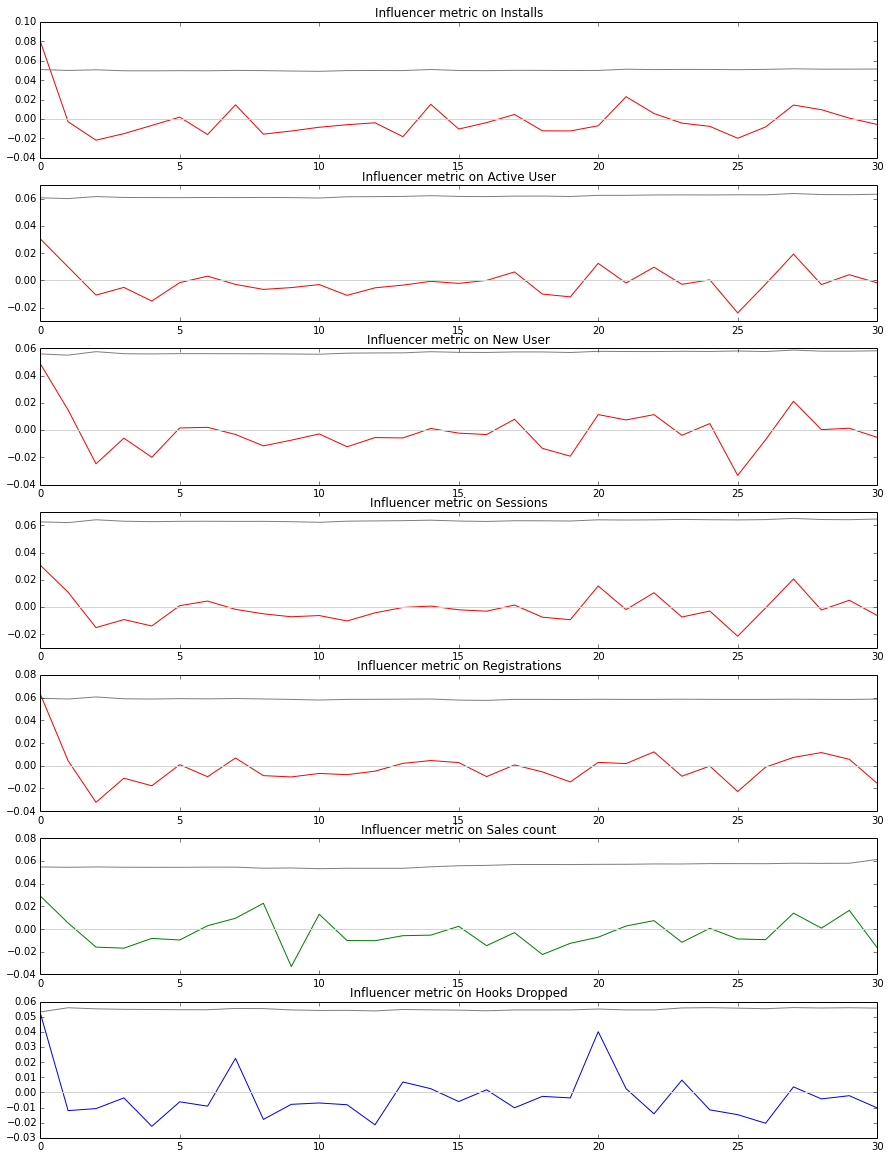

In [28]:
fig = plt.figure(figsize=[15,20])
ax=fig.add_subplot(7,1,1)
ax.set_title('Influencer metric on Installs')
plt.plot(dayLag,onInstalls,'r-',dayLag,np.zeros(len(dayLag)),'lightgrey',dayLag,np.array(autoInstalls)/10-0*np.mean(autoInstalls),'grey')
ax=fig.add_subplot(7,1,2)
ax.set_title('Influencer metric on Active User')
plt.plot(dayLag,onActives,'r-',dayLag,np.zeros(len(dayLag)),'lightgrey',dayLag,np.array(autoActives)/10-0*np.mean(autoActives),'grey')
ax=fig.add_subplot(7,1,3)
ax.set_title('Influencer metric on New User')
plt.plot(dayLag,onNews,'r-',dayLag,np.zeros(len(dayLag)),'lightgrey',dayLag,np.array(autoNews)/10-0*np.mean(autoActives),'grey')
ax=fig.add_subplot(7,1,4)
ax.set_title('Influencer metric on Sessions')
plt.plot(dayLag,onSessions,'r-',dayLag,np.zeros(len(dayLag)),'lightgrey',dayLag,np.array(autoSessions)/10-0*np.mean(autoSessions),'grey')
ax=fig.add_subplot(7,1,5)
ax.set_title('Influencer metric on Registrations')
plt.plot(dayLag,onRegs,'r-',dayLag,np.zeros(len(dayLag)),'lightgrey',dayLag,np.array(autoRegs)/10-0*np.mean(autoRegs),'grey')
ax=fig.add_subplot(7,1,6)
ax.set_title('Influencer metric on Sales count')
plt.plot(dayLag,onSales,'g-',dayLag,np.zeros(len(dayLag)),'lightgrey',dayLag,np.array(autoSales)/10-0*np.mean(autoSales),'grey')
ax=fig.add_subplot(7,1,7)
ax.set_title('Influencer metric on Hooks Dropped')
plt.plot(dayLag,onHooks,'b-',dayLag,np.zeros(len(dayLag)),'lightgrey',dayLag,np.array(autoHooks)/10-0*np.mean(autoHooks),'grey')

#2. Engagement before, during and after free rotation

The rough analysis below categorizes dates for each track into "within free rotation", "within one week after rotation" and "other times". While the engagement during the rotation is clearly the highest, the post-rotation period is very low compared to other times, so a more detailed model is needed.

In [57]:
myfile = pandas.ExcelFile('/home/ms142/museami/Hook\'d in-app track timing.xlsx')
inout= pandas.ExcelFile.parse(myfile,sheetname='Track inout')
inout = inout[pandas.notnull(inout['Track ID'])]
inout.set_index('Track ID',inplace=True)

In [130]:
df=df[3:]
df.set_index(pandas.DatetimeIndex(df.index),inplace=True)

In [201]:
# Rotation type:1 = in free rotation, 2 = within one week after rotation, 0 = other times
def assign_rotation_type(mydate,trackid):
    info = inout.loc[trackid].dropna()
    type = 0
    if (('Start Date' in info.index) & ('Out' in info.index)):
        #         startdate=max(pandas.Timestamp('2014-07-10'),info['Start Date'])           
        if mydate>= info['Start Date']:
            if mydate<info['Out']:
                type=1
                return type
            elif mydate<info['Out']+pandas.Timedelta(days=7):
                type=2
        else:
            return type
    if (('In' in info.index) & ('Out.1' in info.index)):
        if mydate>= info['In']:
            if mydate<info['Out.1']:
                type=1
                return type
            elif mydate<info['Out.1']+pandas.Timedelta(days=7):
                type=2
        else:
            return type
    for i in range(1,len(info)*3):
        if ((('In.'+str(i)) in info.index) & (('Out.'+str(i+1)) in info.index)):
            if mydate>= info['In.'+str(i)]:
                if mydate<info['Out.'+str(i+1)]:
                    type=1
                    return type
                elif mydate<info['Out.'+str(i+1)]+pandas.Timedelta(days=7):
                    type=2
            else:
                return type
    return type


In [202]:
rotation_0 = []
rotation_1 = []
rotation_2 = []

for track in df.columns:
    temp = pandas.DataFrame()
    temp['df']=df[track]
    temp['date'] = df.index
    temp['rotation_type']= temp['date'].apply(assign_rotation_type,trackid=track)
    rotation_0.append(temp[temp['rotation_type']==0]['df'].median())
    rotation_1.append(temp[temp['rotation_type']==1]['df'].median())
    rotation_2.append(temp[temp['rotation_type']==2]['df'].median())
    

In [203]:
rotation_0=np.array(rotation_0)
rotation_1=np.array(rotation_1)
rotation_2=np.array(rotation_2)

In [207]:
analysis=pandas.DataFrame.from_dict({'other times':rotation_0,'within rotation':rotation_1,'post-rotation':rotation_2})

In [208]:
analysis['total']=analysis.sum(axis=1)

In [209]:
analysis[~np.isnan(analysis['total'])].mean()

other times         18.925134
post-rotation        7.455357
within rotation    286.893855
total              300.243316
dtype: float64